In [1]:
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole

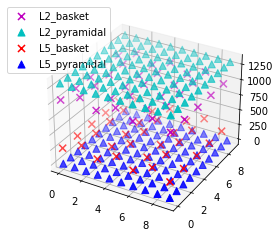

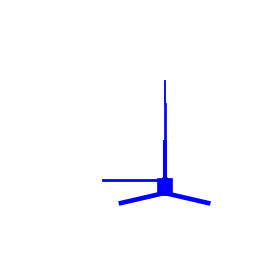

<Axes3DSubplot:>

In [2]:
net = jones_2009_model()
net.plot_cells()
net.cell_types['L5_pyramidal'].plot_morphology()

In [3]:
weights_ampa_d1 = {'L2_basket': 0.006562, 'L2_pyramidal': .000007,
                   'L5_pyramidal': 0.142300}
weights_nmda_d1 = {'L2_basket': 0.019482, 'L2_pyramidal': 0.004317,
                   'L5_pyramidal': 0.080074}
synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                      'L5_pyramidal': 0.1}
net.add_evoked_drive(
    'evdist1', mu=63.53, sigma=3.85, numspikes=1, weights_ampa=weights_ampa_d1,
    weights_nmda=weights_nmda_d1, location='distal',
    synaptic_delays=synaptic_delays_d1, event_seed=4)

In [4]:
weights_ampa_p1 = {'L2_basket': 0.08831, 'L2_pyramidal': 0.01525,
                   'L5_basket': 0.19934, 'L5_pyramidal': 0.00865}
synaptic_delays_prox = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                        'L5_basket': 1., 'L5_pyramidal': 1.}
# all NMDA weights are zero; pass None explicitly
net.add_evoked_drive(
    'evprox1', mu=26.61, sigma=2.47, numspikes=1, weights_ampa=weights_ampa_p1,
    weights_nmda=None, location='proximal',
    synaptic_delays=synaptic_delays_prox, event_seed=4)

# Second proximal evoked drive. NB: only AMPA weights differ from first
weights_ampa_p2 = {'L2_basket': 0.000003, 'L2_pyramidal': 1.438840,
                   'L5_basket': 0.008958, 'L5_pyramidal': 0.684013}
# all NMDA weights are zero; omit weights_nmda (defaults to None)
net.add_evoked_drive(
    'evprox2', mu=137.12, sigma=8.33, numspikes=1,
    weights_ampa=weights_ampa_p2, location='proximal',
    synaptic_delays=synaptic_delays_prox, event_seed=4)

In [5]:
from hnn_core import JoblibBackend

with JoblibBackend(n_jobs=2):
    dpls = simulate_dipole(net, tstop=170., n_trials=2)

joblib will run over 2 jobs
Loading custom mechanism files from /home/kathi/anaconda3/lib/python3.8/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/kathi/anaconda3/lib/python3.8/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
running trial 2 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation 

In [6]:
window_len, scaling_factor = 30, 3000
for dpl in dpls:
    dpl.smooth(window_len).scale(scaling_factor)

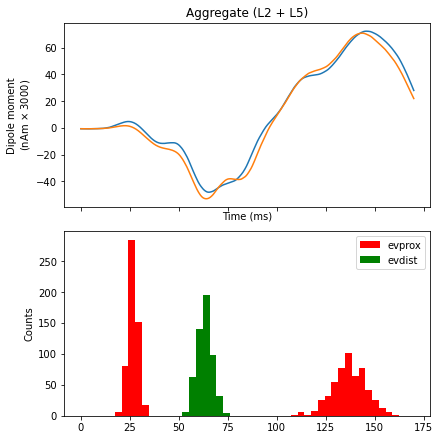

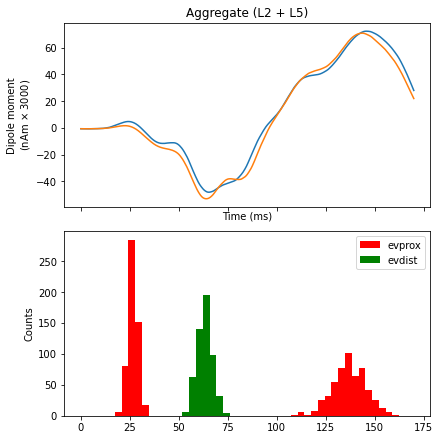

In [7]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6),
                         constrained_layout=True)
plot_dipole(dpls, ax=axes[0], layer='agg', show=False)
net.cell_response.plot_spikes_hist(ax=axes[1],
                                   spike_types=['evprox', 'evdist'])

In [8]:
### having to think about reasonable summary statistics now


####
#1.) mode
#2.) max time
#3.) min time
#4.) max (or better amplitude?)
#5.) min

## sbi analysis comes in: 

import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

agg
L2
L5
agg
L2
L5


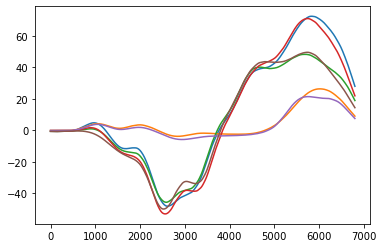

In [9]:
##where are these 6 simulations come from? 
## answer: for both trails, we get data for agg, L2 and L5!

for dpl in dpls:
    for key in dpl.data.keys():
        print(key)
        plt.plot(dpl.data[key])


In [10]:
def syn_current(duration=120, dt=0.01, t_on=10, curr_level=5e-4, seed=None):
    duration = duration
    t_off = duration - t_on
    t = np.arange(0, duration + dt, dt)

    # external current
    A_soma = np.pi * ((70.0 * 1e-4) ** 2)  # cm2
    I = np.zeros_like(t)
    I[int(np.round(t_on / dt)) : int(np.round(t_off / dt))] = (
        curr_level / A_soma
    )  # muA/cm2

    return I, t_on, t_off, dt, t, A_soma

In [11]:
from scipy import stats as spstats

def calculate_summary_statistics(x):
    """Calculate summary statistics
    Parameters
    ----------
    x : output of the simulator
    Returns
    -------
    np.array, summary statistics
    """
    I, t_on, t_off, dt, t, A_soma = syn_current()

    n_mom = 4
    n_summary = 7

    n_summary = np.minimum(n_summary, n_mom + 3)

    t = x["time"]
    dt = x["dt"]

    # initialise array of spike counts
    v = np.array(x["data"])

    # put everything to -10 that is below -10 or has negative slope
    ind = np.where(v < -10)
    v[ind] = -10
    ind = np.where(np.diff(v) < 0)
    v[ind] = -10

    # remaining negative slopes are at spike peaks
    ind = np.where(np.diff(v) < 0)
    spike_times = np.array(t)[ind]
    spike_times_stim = spike_times[(spike_times > t_on) & (spike_times < t_off)]

    # number of spikes
    if spike_times_stim.shape[0] > 0:
        spike_times_stim = spike_times_stim[
            np.append(1, np.diff(spike_times_stim)) > 0.5
        ]

    # resting potential and std
    rest_pot = np.mean(x["data"][t < t_on])
    rest_pot_std = np.std(x["data"][int(0.9 * t_on / dt) : int(t_on / dt)])

    # moments
    std_pw = np.power(
        np.std(x["data"][(t > t_on) & (t < t_off)]), np.linspace(3, n_mom, n_mom - 2)
    )
    std_pw = np.concatenate((np.ones(1), std_pw))
    moments = (
        spstats.moment(
            x["data"][(t > t_on) & (t < t_off)], np.linspace(2, n_mom, n_mom - 1)
        )
        / std_pw
    )

    # concatenation of summary statistics
    sum_stats_vec = np.concatenate(
        (
            np.array([spike_times_stim.shape[0]]),
            np.array(
                [rest_pot, rest_pot_std, np.mean(x["data"][(t > t_on) & (t < t_off)])]
            ),
            moments,
        )
    )
    sum_stats_vec = sum_stats_vec[0:n_summary]

    return sum_stats_vec

In [12]:


def simulation_wrapper(net):
    """
    Returns summary statistics from conductance values in `params`.

    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    with JoblibBackend(n_jobs=1):
        dpls = simulate_dipole(net, tstop=170., n_trials=1)
    for dpl in dpls:
        obs = dpl.data['agg']
    
    
    return obs

In [48]:
print(net._params)

{
    "L2Basket_Gauss_A_weight": 0.0,
    "L2Basket_Gauss_mu": 2000.0,
    "L2Basket_Gauss_sigma": 3.6,
    "L2Basket_Pois_A_weight_ampa": 0.0,
    "L2Basket_Pois_A_weight_nmda": 0.0,
    "L2Basket_Pois_lamtha": 0.0,
    "L2Pyr_Gauss_A_weight": 0.0,
    "L2Pyr_Gauss_mu": 2000.0,
    "L2Pyr_Gauss_sigma": 3.6,
    "L2Pyr_Pois_A_weight_ampa": 0.0,
    "L2Pyr_Pois_A_weight_nmda": 0.0,
    "L2Pyr_Pois_lamtha": 0.0,
    "L2Pyr_ampa_e": 0.0,
    "L2Pyr_ampa_tau1": 0.5,
    "L2Pyr_ampa_tau2": 5.0,
    "L2Pyr_apical1_L": 306.0,
    "L2Pyr_apical1_diam": 4.08,
    "L2Pyr_apicaloblique_L": 340.0,
    "L2Pyr_apicaloblique_diam": 3.91,
    "L2Pyr_apicaltrunk_L": 59.5,
    "L2Pyr_apicaltrunk_diam": 4.25,
    "L2Pyr_apicaltuft_L": 238.0,
    "L2Pyr_apicaltuft_diam": 3.4,
    "L2Pyr_basal1_L": 85.0,
    "L2Pyr_basal1_diam": 4.25,
    "L2Pyr_basal2_L": 255.0,
    "L2Pyr_basal2_diam": 2.72,
    "L2Pyr_basal3_L": 255.0,
    "L2Pyr_basal3_diam": 2.72,
    "L2Pyr_dend_Ra": 200.0,
    "L2Pyr_dend_cm": 0.619

In [49]:
## prior which parameters? --> all that go into simulator???
## evoked primal/distal...

prox_drive1 = 137.12
dist_drive2 = 63.53
prox_drive3 = 26.61

prior_min = torch.Tensor([0]).repeat(230)
print(prior_min)
prior_max = torch.Tensor([1001]).repeat(230)
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

RuntimeError: The size of tensor a (230) must match the size of tensor b (0) at non-singleton dimension 0

In [21]:
posterior = infer(simulation_wrapper, prior, method='SNPE_C', 
                  num_simulations=20, num_workers=4)

joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Sim

Running 20 simulations in 20 batches.:   0%|          | 0/20 [00:00<?, ?it/s]

Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
joblib will run over 1 jobs
joblib will run over 1 jobs
joblib will run over 1 jobs
joblib will run over 1 jobs
Loading custom mechanism files from /home/kathi/anaconda3/lib/python3.8/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/kathi/anaconda3/lib/python3.8/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/kathi/anaconda3/lib/python3.8/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/kathi/anaconda3/lib/python3.8/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
[Done]
running trial 1 on 1 cores
S

Running 20 simulations in 20 batches.:   5%|▌         | 1/20 [06:48<2:09:21, 408.48s/it]

joblib will run over 1 jobs


Running 20 simulations in 20 batches.:  10%|█         | 2/20 [06:52<51:11, 170.62s/it]  

joblib will run over 1 jobs


Running 20 simulations in 20 batches.:  20%|██        | 4/20 [06:55<15:09, 56.86s/it]

joblib will run over 1 jobs
joblib will run over 1 jobs
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simu

Running 20 simulations in 20 batches.:  25%|██▌       | 5/20 [10:18<27:22, 109.51s/it]

joblib will run over 1 jobs


Running 20 simulations in 20 batches.:  30%|███       | 6/20 [10:19<16:58, 72.76s/it] 

joblib will run over 1 jobs
Building the NEURON model


Running 20 simulations in 20 batches.:  35%|███▌      | 7/20 [10:20<10:40, 49.24s/it]

joblib will run over 1 jobs


Running 20 simulations in 20 batches.:  40%|████      | 8/20 [10:21<06:45, 33.79s/it]

Building the NEURON model
joblib will run over 1 jobs
Building the NEURON model
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...
Si

Running 20 simulations in 20 batches.:  45%|████▌     | 9/20 [13:41<15:43, 85.77s/it]

joblib will run over 1 jobs


Running 20 simulations in 20 batches.:  50%|█████     | 10/20 [13:42<09:57, 59.77s/it]

Building the NEURON model
joblib will run over 1 jobs
Building the NEURON model


Running 20 simulations in 20 batches.:  55%|█████▌    | 11/20 [13:44<06:17, 41.97s/it]

joblib will run over 1 jobs


Running 20 simulations in 20 batches.:  60%|██████    | 12/20 [13:45<03:55, 29.47s/it]

joblib will run over 1 jobs
Building the NEURON model
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...


Running 20 simulations in 20 batches.:  65%|██████▌   | 13/20 [16:48<08:52, 76.07s/it]

joblib will run over 1 jobs
Building the NEURON model


Running 20 simulations in 20 batches.:  70%|███████   | 14/20 [16:52<05:25, 54.29s/it]

joblib will run over 1 jobs
Building the NEURON model


Running 20 simulations in 20 batches.:  75%|███████▌  | 15/20 [16:54<03:12, 38.47s/it]

joblib will run over 1 jobs


Running 20 simulations in 20 batches.:  80%|████████  | 16/20 [16:54<01:48, 27.04s/it]

joblib will run over 1 jobs
Building the NEURON model
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...


Running 20 simulations in 20 batches.:  85%|████████▌ | 17/20 [19:47<03:32, 70.91s/it]

Simulation time: 160.0 ms...
Simulation time: 160.0 ms...


Running 20 simulations in 20 batches.: 100%|██████████| 20/20 [19:55<00:00, 59.76s/it]


Neural network successfully converged after 50 epochs.


In [24]:
true_params = np.array([137.12, 63.53, 26.61])

samples = posterior.sample((10000,), 
                           x=dpl.data['agg'])

Drawing 10000 posterior samples: 10032it [03:19, 50.29it/s]
